In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from collections import defaultdict

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from xgboost import XGBRegressor
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample

import pickle
from IPython.display import clear_output 

In [2]:
#convert fractional betting spread strings into floats

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [3]:
#import data
training_df = pd.read_csv('training_data.csv')
training_df.rename(columns={'HOME_TEAM_ID':'TEAM_ID_HOME', 'HOME_TEAM_CITY':'TEAM_CITY_HOME'}, inplace=True)
print('Shape: ', training_df.shape)
training_df.columns

Shape:  (27198, 52)


Index(['Unnamed: 0', 'USG_PCT', 'E_OFF_RATING', 'DREB_PCT', 'FG3M',
       'E_DEF_RATING', 'AST_TOV', 'FG3_PCT', 'PACE', 'POSS', 'OREB',
       'TM_TOV_PCT', 'FGM', 'FTM', 'OFF_RATING', 'FG3A', 'E_NET_RATING',
       'TS_PCT', 'FGA', 'BLK', 'PTS', 'PACE_PER40', 'E_TM_TOV_PCT',
       'E_USG_PCT', 'AST', 'FTA', 'ELO', 'E_PACE', 'AST_PCT', 'WL', 'FG_PCT',
       'REB', 'REB_PCT', 'FT_PCT', 'MIN', 'DREB', 'PF', 'NET_RATING',
       'AST_RATIO', 'OREB_PCT', 'EFG_PCT', 'TOV', 'STL', 'PIE', 'DEF_RATING',
       'PLUS_MINUS', 'SEASON', 'GAME_DATE', 'GAME_ID', 'TEAM_ID_HOME',
       'TEAM_CITY_HOME', 'SPREAD'],
      dtype='object')

In [4]:
#Create standardized dataset
training_df.drop(columns=['Unnamed: 0',
                 'TEAM_ID_HOME',
                 'GAME_DATE',
                 'TEAM_CITY_HOME',
                 'SEASON'], inplace=True)

non_feature_cols = {'GAME_ID', 'SPREAD'}
feature_cols = set(training_df.columns) - non_feature_cols

#standardize features
sclr = StandardScaler()
training_df[list(feature_cols)] = sclr.fit_transform(training_df[list(feature_cols)])
training_df.head()

,USG_PCT,E_OFF_RATING,DREB_PCT,FG3M,E_DEF_RATING,AST_TOV,FG3_PCT,PACE,POSS,OREB,...,AST_RATIO,OREB_PCT,EFG_PCT,TOV,STL,PIE,DEF_RATING,PLUS_MINUS,GAME_ID,SPREAD
0,0.0,-0.083263,0.586988,0.235999,-0.300081,-1.301331,0.594792,-0.734833,-0.726893,0.311414,...,-0.801753,1.034106,0.233565,0.971326,0.232005,0.262788,-0.399198,0.159391,20000721,21.0
1,0.0,0.776465,1.049826,0.914501,-1.617526,0.706401,1.620533,-0.492022,-0.355606,-1.674895,...,0.572743,-1.669598,0.199867,-1.327725,1.246447,1.769843,-1.583842,1.303332,20000711,2.0
2,0.0,0.081771,1.186924,0.112518,-0.223413,-0.562539,1.464594,0.697328,0.732349,1.227092,...,-0.201523,1.082764,0.460243,1.109593,-1.036566,0.454775,-0.232986,0.208704,20000726,19.0
3,0.0,0.826054,-0.638708,-0.477976,0.714151,0.099633,1.473665,-0.055466,-0.215476,0.754982,...,0.201954,0.875168,0.806178,0.217327,-1.305649,0.264774,0.711068,0.079000,20000734,-20.0
4,0.0,0.790841,0.376923,-0.438253,1.752350,2.191650,0.272570,1.045300,0.912994,2.374091,...,1.235605,1.935370,0.003821,-0.447850,-0.534501,-0.530627,1.658869,-0.358371,20000729,-7.0


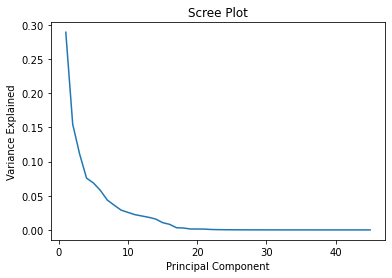

In [5]:
#PCA to minimize multicollinearity
pca = PCA().fit(training_df[list(feature_cols)])
principal_components = np.arange(pca.n_components_)+1
plt.plot(principal_components, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [6]:
#apply dimensionality reduction to data, keeping n components
n_components = 20
pca=PCA(n_components=n_components)

df_ids_spreads = training_df[list(non_feature_cols)].copy()

df_pca = pd.DataFrame(pca.fit_transform(training_df[list(feature_cols)]))
df_pca['GAME_ID'] = df_ids_spreads['GAME_ID']
df_pca['SPREAD'] = df_ids_spreads['SPREAD']
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,GAME_ID,SPREAD
0,0.921976,-2.146900,-2.460733,1.120665,-1.761254,-0.452624,1.119262,-0.663066,-0.410643,-1.105213,...,-0.282082,-1.544775,-0.900550,0.137079,0.038758,-0.196785,0.242208,-0.069132,20000721,21.0
1,-4.190672,-2.600735,1.861792,0.697790,-0.520923,-1.884194,-3.035097,1.143921,-2.594843,0.469098,...,-2.275690,-1.072344,-0.883910,-0.214702,-0.158418,-0.180932,-0.086796,0.311843,20000711,2.0
2,-1.168993,1.448401,-3.122693,-0.743124,0.874135,-0.310195,2.661085,0.336003,0.575958,-0.661302,...,-1.838836,-0.376442,-0.861972,0.046072,-0.580808,-0.009028,0.015247,-0.062907,20000726,19.0
3,-1.631536,0.282883,-0.707663,-0.566931,-0.781657,1.701270,2.293772,0.540647,1.165011,-0.954931,...,-0.136680,-0.571499,-1.019391,-0.833450,0.253202,0.360490,-0.041421,-0.187040,20000734,-20.0
4,-1.349064,3.822397,-0.246166,-3.133159,1.910998,3.858545,1.902862,0.038047,-0.641724,-0.226469,...,0.596319,1.002352,-0.473085,1.073567,-0.026999,0.171547,-0.086132,-0.142364,20000729,-7.0


In [7]:
#split data into X_train and y_train
y_train = df_pca['SPREAD'].copy()
X_train = df_pca.drop(columns=['SPREAD', 'GAME_ID'])
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.921976,-2.146900,-2.460733,1.120665,-1.761254,-0.452624,1.119262,-0.663066,-0.410643,-1.105213,0.252116,-0.817244,-0.282082,-1.544775,-0.900550,0.137079,0.038758,-0.196785,0.242208,-0.069132
1,-4.190672,-2.600735,1.861792,0.697790,-0.520923,-1.884194,-3.035097,1.143921,-2.594843,0.469098,-2.133990,-0.300726,-2.275690,-1.072344,-0.883910,-0.214702,-0.158418,-0.180932,-0.086796,0.311843
2,-1.168993,1.448401,-3.122693,-0.743124,0.874135,-0.310195,2.661085,0.336003,0.575958,-0.661302,0.389069,-0.276915,-1.838836,-0.376442,-0.861972,0.046072,-0.580808,-0.009028,0.015247,-0.062907
3,-1.631536,0.282883,-0.707663,-0.566931,-0.781657,1.701270,2.293772,0.540647,1.165011,-0.954931,1.116336,0.283811,-0.136680,-0.571499,-1.019391,-0.833450,0.253202,0.360490,-0.041421,-0.187040
4,-1.349064,3.822397,-0.246166,-3.133159,1.910998,3.858545,1.902862,0.038047,-0.641724,-0.226469,1.267327,0.598742,0.596319,1.002352,-0.473085,1.073567,-0.026999,0.171547,-0.086132,-0.142364


In [9]:
#XGBoost implementation
xgb = pickle.load(open('model_latest.pkl', 'rb'))
xgb.fit(X_train, y_train)

#pickle updated model
pickle.dump(xgb, open('model.pkl', 'wb'))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.09174712008617064, eval_metric=None,
             gamma=17.699972942721537, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.09174712, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=2.0,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0, ...)

In [20]:
#load data for evaluation
eval_df = pd.read_csv('eval_data.csv')
eval_df.drop(columns=['Unnamed: 0',
                 'GAME_DATE',
                 'SEASON',
                 'HOME_TEAM_ID',
                 'HOME_TEAM_CITY'], inplace=True)
eval_df.head()

,USG_PCT,E_OFF_RATING,DREB_PCT,FG3M,E_DEF_RATING,AST_TOV,FG3_PCT,PACE,POSS,OREB,...,AST_RATIO,OREB_PCT,EFG_PCT,TOV,STL,PIE,DEF_RATING,PLUS_MINUS,GAME_ID,SPREAD
0,0.0,-2.469720,0.010007,-2.672748,4.345179,0.205198,-0.005148,3.121716,3.476832,-0.460093,...,1.743200,-0.012904,-0.011314,0.461064,0.323153,-0.012569,4.525927,-7.374078,NaN,NaN
1,0.0,-9.653938,0.022861,0.126411,1.665538,-0.181297,-0.024829,3.928911,3.641544,-4.680069,...,1.597012,-0.083183,-0.016566,2.105635,-1.663254,-0.030014,1.434179,-11.583978,NaN,NaN
2,0.0,5.316083,0.016496,1.344069,-15.658195,0.121398,0.012437,-2.424437,-2.735128,-1.581533,...,0.558003,-0.046567,0.025794,-1.296305,0.057874,0.109098,-14.391669,17.596592,NaN,NaN
3,0.0,-1.168178,-0.036203,2.441446,0.156865,-0.193507,0.004705,0.483153,0.376387,0.101116,...,-0.117391,0.016458,0.011533,2.011866,0.370381,-0.014156,0.952700,-1.303049,NaN,NaN
4,0.0,6.207597,0.059176,1.948218,-0.506864,-0.041588,-0.001445,3.719525,3.290428,0.895801,...,-0.639473,0.013332,0.028925,0.477239,0.329384,0.027397,-0.927337,7.093560,NaN,NaN


In [21]:
#standardize features for eval data
eval_df[list(feature_cols)] = sclr.transform(eval_df[list(feature_cols)])

#pca on eval data
eval_df = pd.DataFrame(pca.transform(eval_df[list(feature_cols)]))

eval_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.523868,2.838480,0.730311,0.471793,2.184919,1.816028,-0.595462,2.434894,0.066188,-0.310763,0.965328,0.116698,-1.847131,-0.450896,-0.004108,1.366478,0.011362,-0.574170,0.198054,0.085000
1,3.771220,1.932957,1.480034,3.613804,2.670993,-2.686297,0.497903,3.473516,-1.422820,-0.104733,0.193052,0.990395,0.231277,0.112203,0.483556,0.043811,0.269460,-0.257773,0.487435,0.625442
2,-6.755964,-4.397669,-1.851504,0.455849,0.814690,-2.751055,-1.259076,0.213376,0.788780,0.295776,-0.585948,0.954490,1.193287,-0.140382,0.105591,-0.918644,0.624341,-0.720399,-0.705057,-0.213050
3,0.968692,1.143675,-0.563477,2.009077,-0.794104,-0.428560,0.737578,-2.221908,-0.218192,0.223632,0.721627,0.098045,0.157051,0.887158,0.175516,-0.512613,0.391374,-0.288863,0.335109,0.056949
4,-4.085437,1.909594,-2.880867,-1.275575,-1.048250,-1.047746,1.384767,0.796081,-1.239702,-1.571726,-1.293445,-1.300488,0.656835,-0.356719,0.186406,0.547294,-0.062257,0.084723,-0.160780,0.090809


In [22]:
#generate spread predictions
y_pred = xgb.predict(eval_df)
y_pred

array([-2.260802  , -6.986599  , 12.983214  , -0.05824432,  9.400148  ,
        0.48778352,  1.2411057 ,  9.788942  ,  2.658452  , -3.6977818 ],
      dtype=float32)

In [24]:
#import betting data
spreads_df = pd.read_csv('daily_spreads_df.csv')
spreads_df.drop(columns=['Unnamed: 0'], inplace=True)
spreads_df.head()

,GM_DATE,HOME_TEAM,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME
0,2022-04-01,Washington,-7½,-110,-7½,-110,NaN,-,-7½,-118,+7½,-110,+7½,-110,NaN,-,+7½,-118
1,2022-04-01,Orlando,-11½,-110,-11½,-107,NaN,-,-10½,-125,+11½,-110,+11½,-114,NaN,-,+11½,-111
2,2022-04-01,Boston,+15,-110,+15½,-109,NaN,-,+14½,100,-15,-110,-15½,-112,NaN,-,-15½,-118
3,2022-04-01,Houston,-3,-110,-3½,-110,NaN,-,-3½,-111,+3,-110,+3½,-110,NaN,-,+3½,-125
4,2022-04-01,Milwaukee,+3½,-105,+3½,-109,NaN,-,+3½,-118,-3½,-115,-3½,-112,NaN,-,-3½,-118


In [25]:
print(len(y_pred))
print(len(spreads_df))

10
10


In [ ]:
#compare predicted spreads against betting spreads

for i, row in spreads_df.iterrows():
    